# HetRec 2011
---
The 2nd International Workshop on Information Heterogeneity and Fusion in Recommender Systems (HetRec 2011, http://ir.ii.uam.es/hetrec2011) has released datasets from Delicious, Last.fm Web 2.0, MovieLens, IMDb, and Rotten Tomatoes. These datasets contain social networking, tagging, and resource consuming (Web page bookmarking and music artist listening) information from sets of around 2,000 users.

The datasets were generated by the Information Retrieval Group at Universidad Autónoma de Madrid (http://ir.ii.uam.es). Before using these datasets, please review the README files for the usage license and other details.

---
**MUSIC RECOMMENDER SYSTEM**

In [1]:
import numpy as np
import pandas as pd

import csv
import os

from tqdm.notebook import tqdm

from scipy.spatial.distance import cdist

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn

import fasttext
import fasttext.util

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Data loading & correction
---

In [2]:
def dat_to_csv(dat_file, has_header=True, delimiter=',', save=False):
    with open(dat_file, 'r', encoding='cp437') as f:
        lines = f.read().split('\n')[:-1]
    
    if has_header:
        columns = lines[0].split(delimiter)
        lines = lines[1:]
    else:
        columns = [f'Column {i}' for i in range(len(lines[0].split(delimiter)))]
    
    df = pd.DataFrame(np.array([l.split(delimiter) for l in lines]), columns=columns)
    if save:
        df.to_csv(dat_file.replace('.dat', '.csv'))
    
    return df

## Last.FM dataset

In [3]:
df_lf_artists = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/artists.dat', delimiter='\t')
df_lf_tags = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/tags.dat', delimiter='\t')
df_lf_userweighted = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/user_artists.dat', delimiter='\t')
df_lf_usertagged = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat', delimiter='\t')

In [4]:
df_lf_artists = df_lf_artists[['id', 'name']]
df_lf_artists.head()

,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


In [5]:
df_lf_tags = df_lf_tags.rename(columns={'tagID': 'id', 'tagValue': 'value'})
df_lf_tags.head()

,id,value
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [6]:
df_lf_userweighted.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [7]:
df_lf_usertagged = df_lf_usertagged[['userID', 'artistID', 'tagID']]
df_lf_usertagged.head()

,userID,artistID,tagID
0,2,52,13
1,2,52,15
2,2,52,18
3,2,52,21
4,2,52,41


In [8]:
print(f'Artists: {len(df_lf_artists)}')
print(f'Tags: {len(df_lf_tags)}')
print(f'Artist user weightings: {len(df_lf_userweighted)}')
print(f'Artist user taggings: {len(df_lf_usertagged)}')

Artists: 17632
Tags: 11946
Artist user weightings: 92834
Artist user taggings: 186479


## Artists and users ids correction

First change indices data type from 'str' appropriately to 'np.int32' or 'np.float32'.

In [9]:
df_lf_usertagged['userID'] = df_lf_usertagged['userID'].astype(np.int32)
df_lf_usertagged['artistID'] = df_lf_usertagged['artistID'].astype(np.int32)
df_lf_usertagged['tagID'] = df_lf_usertagged['tagID'].astype(np.int32)

df_lf_userweighted['userID'] = df_lf_userweighted['userID'].astype(np.int32)
df_lf_userweighted['artistID'] = df_lf_userweighted['artistID'].astype(np.int32)
df_lf_userweighted['weight'] = df_lf_userweighted['weight'].astype(np.int32)

df_lf_artists['id'] = df_lf_artists['id'].astype(np.int32)

df_lf_tags['id'] = df_lf_tags['id'].astype(np.int32)

In [10]:
users = df_lf_userweighted['userID'].values
items = df_lf_userweighted['artistID'].values
ui_weightings = df_lf_userweighted['weight'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Weightings: {len(ui_weightings)}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 1892
Items: 17632
Weightings: 92834
Max user_id: 2100
Max item_id: 18745


Maximum user index 2100 and item index 18745 are out of range: 1892 and 17632. Need to reset indices for weighting prediction task.

In [11]:
user_mapping = dict(zip(np.unique(users), np.arange(n_users)))
item_mapping = dict(zip(np.unique(items), np.arange(n_items)))

In [12]:
user_rev_mapping = dict({v: k for k, v in user_mapping.items()})
item_rev_mapping = dict({v: k for k, v in item_mapping.items()})

In [13]:
df_lf_userweighted['fixed_userID'] = df_lf_userweighted['userID'].replace(user_mapping)
df_lf_userweighted['fixed_artistID'] = df_lf_userweighted['artistID'].replace(item_mapping)

In [14]:
users = df_lf_userweighted['fixed_userID'].values
items = df_lf_userweighted['fixed_artistID'].values
ui_weightings = df_lf_userweighted['weight'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 1892
Items: 17632
Max user_id: 1891
Max item_id: 17631


Now it's ok.

# Artists recommendation
---
Aspects according to given user id:
- predicted artist weightings for user (matrix factorization / deep learning)
- artist names similarity (content based approach)
- artist user tagging similarity (collaborative filtering approach)
---
Let's perform artists recommendation for users 190 (new **180**) and 622 (new **578**).

In [15]:
USER01, USER02 = 127, 1355

print(f'User {USER01} --> weighting user: {user_mapping[USER01]}')
print(f'User {USER02} --> weighting user: {user_mapping[USER02]}')

User 127 --> weighting user: 122
User 1355 --> weighting user: 1227


## Weighting - Dense Feedforward NN

In [16]:
def user_weightings(user_id):
    df_common = df_lf_userweighted.merge(df_lf_artists, left_on='artistID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['artistID', 'name', 'weight']]\
    .sort_values('weight', ascending=False)

In [17]:
df_user01_weightings = user_weightings(USER01)
df_user01_weightings.head(10)

,artistID,name,weight
51938,1672,Avenged Sevenfold,2566
39274,951,Bon Jovi,2254
63093,1927,Lovex,1718
63096,3082,Framing Hanley,1597
61093,2790,CRASHD├ÅET,1574
39354,952,Skid Row,1307
36653,854,Alice in Chains,1140
27967,533,Oasis,952
53404,1803,M├╢tley Cr├╝e,831
38579,918,Megadeth,812


In [18]:
df_user02_weightings = user_weightings(USER02)
df_user02_weightings.head(10)

,artistID,name,weight
30161,606,Jos├⌐ Gonz├ílez,1622
7686,205,Andrew Bird,610
58400,2424,The New Pornographers,557
59626,2584,Rogue Wave,526
84920,11589,The Dodos,486
63953,3249,Radical Face,455
50210,1481,Matt & Kim,433
7072,196,Beirut,402
88136,14063,Cellofourte,374
79399,8234,Kronos Quartet,369


### Helpers

In [19]:
def batch(l, size):
    for i in range(0, len(l), size):
        yield l[i:i+size]

### Model

In [20]:
class DenseNet(torch.nn.Module):

    def __init__(self, n_users, n_items, n_factors, H1, D_out):
        """
        Simple Feedforward with Embeddings
        """
        super().__init__()
        # user and item embedding layers
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)
        # dropout after embeddings
        self.dropout1 = torch.nn.Dropout(0.1)
        # linear layers
        self.linear1 = torch.nn.Linear(n_factors*2, H1)
        self.linear2 = torch.nn.Linear(H1, H1)
        self.linear3 = torch.nn.Linear(H1, H1)
        self.linear4 = torch.nn.Linear(H1, D_out)
        # dropout after linear layers
        self.dropout2 = torch.nn.Dropout(0.1)

    def forward(self, users, items):
        users_embedding = self.user_factors(users)
        items_embedding = self.item_factors(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([users_embedding, items_embedding], 1)
        x = self.dropout1(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.dropout2(self.linear4(x))
        output_scores = F.relu(x)
        
        return output_scores

    def predict(self, users, items):
        # return the score
        output_scores = self.forward(users, items)
        return output_scores

In [21]:
class WeightingPredictor():
    
    def __init__(self, user_ids, item_ids, ui_weightings, n_factors, h1):
        """
        Artist weightings predictor for all users.
        """
        self.user_ids = user_ids
        self.item_ids = item_ids
        
        self.ui_weightings = ui_weightings
        self.n_users = np.size(np.unique(user_ids))
        self.n_items = np.size(np.unique(item_ids))
        
        self.n_factors = n_factors
        self.h1 = h1
        
        self.__model = DenseNet(self.n_users, self.n_items, n_factors=self.n_factors, H1=self.h1, D_out=1)
        self.__loss = torch.nn.MSELoss()
        self.__optim = torch.optim.SGD(self.__model.parameters(), lr=1e-6)
        
    
    def fit(self, epochs, batch_size, save_progress=False):
        if save_progress:
            with open(f'hetrec2011/aw_prog_{self.n_factors}f_{self.h1}h.csv', 'w') as f:
                csv.writer(f).writerow(['epoch loss'])
        
        t = tqdm(range(epochs))
        for epoch in t:
            t.set_postfix_str(f'Epoch {epoch + 1}/{epochs}')
            us_b = batch(self.user_ids, size=batch_size)
            is_b = batch(self.item_ids, size=batch_size)
            uiws_b = batch(self.ui_weightings, size=batch_size)
            epoch_loss = 0
            
            tt = tqdm(zip(us_b, is_b, uiws_b),
                      total=int(np.size(self.ui_weightings)/batch_size + 1), leave=False)
            for u, i, uiw in tt:
                # get user, item and weight data batch
                user = Variable(torch.LongTensor(u))
                item = Variable(torch.LongTensor(i))
                weight = Variable(torch.FloatTensor(uiw))

                # predict
                prediction = self.__model(user, item)
                #target = (prediction.reshape(-1) <= weight).int() - (prediction.reshape(-1) > weight).int()
                loss = self.__loss(prediction.reshape(-1), weight)
                epoch_loss += loss.detach().numpy()
                tt.set_postfix_str(f'Current MSE loss: {np.round(np.float64(loss.detach().numpy()), 4)} ' +
                                   f'| Total: {np.round(epoch_loss, 4)}')

                # backpropagate
                loss.backward()

                # update weights
                self.__optim.step()
            
            #save current artist-weighting progress step
            if save_progress:
                with open(f'hetrec2011/aw_prog_{self.n_factors}f_{self.h1}h.csv', 'a+') as f:
                    csv.writer(f).writerow([epoch_loss])
    
    def predict(self, user_id):
        user_id = user_mapping[user_id]
        users_tensor = torch.tensor([user_id]*np.size(self.item_ids))
        items_tensor = torch.tensor(self.item_ids)
        return self.__model(users_tensor, items_tensor).flatten().detach().numpy()

### Tests

In [22]:
BATCH_SIZE = 64
EPOCHS = 1

In [23]:
INPUT_FACTORS = 20
HIDDEN_FACTORS = 60

In [24]:
WP_MODEL_PATH = f'hetrec2011/wp_model_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h'

In [25]:
df_userweighted_names = df_lf_userweighted.merge(df_lf_artists, left_on='artistID', right_on='id')
df_userweighted_names

,userID,artistID,weight,fixed_userID,fixed_artistID,id,name
0,2,51,13883,0,45,51,Duran Duran
1,4,51,228,2,45,51,Duran Duran
2,27,51,85,24,45,51,Duran Duran
3,28,51,10,25,45,51,Duran Duran
4,62,51,528,59,45,51,Duran Duran
...,...,...,...,...,...,...,...
92829,2100,18726,337,1891,17615,18726,Nyktalgia
92830,2100,18727,297,1891,17616,18727,Atsakau niekadA
92831,2100,18728,281,1891,17617,18728,Domantas Razauskas
92832,2100,18729,280,1891,17618,18729,Atalyja


In [26]:
if not os.path.exists(WP_MODEL_PATH):
    wp = WeightingPredictor(
        df_userweighted_names['fixed_userID'].values,
        df_userweighted_names['fixed_artistID'].values,
        df_userweighted_names['weight'].values,
        n_factors=INPUT_FACTORS, h1=HIDDEN_FACTORS)
    wp.fit(epochs=EPOCHS, batch_size=BATCH_SIZE, save_progress=True)
    torch.save(wp, WP_MODEL_PATH)
else:
    wp = torch.load(WP_MODEL_PATH)

In [27]:
def prediction_quality_plot(input_file, title, save_file=None):
    df = pd.read_csv(input_file)
    
    plt.plot(df.index + 1, df['epoch loss'], label='epoch MSE loss')
    plt.scatter(df.index + 1, df['epoch loss'])
    plt.xticks(df.index + 1)
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    for k, v in zip(df.index + 1, df['epoch loss']):
        plt.annotate(np.round(v, 4), (k, v), size=16, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(loc='best')
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

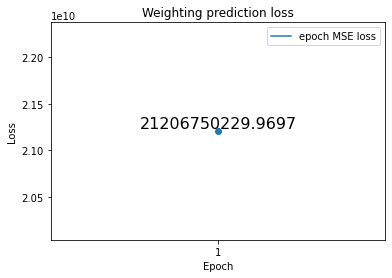

In [28]:
prediction_quality_plot(input_file=f'hetrec2011/aw_prog_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h.csv',
                        title='Weighting prediction loss',
                        save_file=f'hetrec2011/weighting_prediction_loss_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h.png')

In [29]:
def weightings_recommendations(df, predictions):
    df_all = pd.DataFrame({
        'artistID': df['artistID'].values,
        'name': df['name'].values,
        'pred. weight': predictions
    }).drop_duplicates()
    
    df_all = df_all.groupby(['artistID', 'name'])['pred. weight'].apply(np.max).to_frame().reset_index()
    
    return df_all.sort_values('pred. weight', ascending=False)

In [30]:
df_user01_weightings_recommendations = weightings_recommendations(df_userweighted_names, wp.predict(USER01))
df_user01_weightings_recommendations

,artistID,name,pred. weight
11001,11372,Absu,287.001923
7968,8161,T-Pain,232.503967
1420,1429,Christian Ch├ívez,140.800369
677,683,John Mayer,130.395248
2920,2940,Dead by April,125.146935
...,...,...,...
3259,3296,The Primitives,0.000000
10110,10395,Roots Manuva,0.000000
10112,10397,Cool Calm Pete,0.000000
3256,3293,Black Kids,0.000000


In [31]:
df_user02_weightings_recommendations = weightings_recommendations(df_userweighted_names, wp.predict(USER02))
df_user02_weightings_recommendations

,artistID,name,pred. weight
12791,13279,Vaya Con Dios,309.938843
973,982,Foo Fighters,176.451691
285,291,Kelly Clarkson,172.188461
4078,4162,Lacrimas Profundere,158.016251
452,458,Justin Bieber,122.672516
...,...,...,...
10034,10319,Lady Gaga feat Beyonc├⌐,0.000000
10036,10321,Ginger Ninja,0.000000
10037,10322,O.A.R.,0.000000
3259,3296,The Primitives,0.000000


## Titles - Content Based Approach

Each artist has name. Task is to calculate cosine similarity of vectorized names.

In [32]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [33]:
names = df_lf_artists['name'].values
names_embeddings = np.array([ft_model[n] for n in names])

In [34]:
del ft_model

In [35]:
cosine_mtx = cdist(names_embeddings, names_embeddings, 'cosine')
cosine_mtx = np.subtract(np.ones(cosine_mtx.shape), cosine_mtx)

df_cosine_sim = pd.DataFrame(cosine_mtx,
                             index=df_lf_artists['id'].values,
                             columns=df_lf_artists['id'].values)
df_cosine_sim

,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
1,1.000000,0.474865,0.489505,0.314527,0.393050,0.202281,0.479717,0.313752,0.148893,0.203693,...,0.218983,0.288147,0.190463,0.345959,0.426064,0.342597,0.303223,0.355858,0.289311,0.464350
2,0.474865,1.000000,0.550310,0.356823,0.566883,0.090654,0.529828,0.402167,0.036982,0.113198,...,0.262914,0.547074,-0.021143,0.378701,0.427511,0.295467,0.146932,0.578920,0.327925,0.504941
3,0.489505,0.550310,1.000000,0.387340,0.515359,0.145962,0.470031,0.320694,0.047589,0.158989,...,0.246005,0.358409,0.092532,0.356065,0.435052,0.346365,0.217965,0.485101,0.306268,0.386451
4,0.314527,0.356823,0.387340,1.000000,0.389738,0.128492,0.451046,0.381914,0.117615,0.076289,...,0.291228,0.249575,0.124406,0.428410,0.342176,0.285429,0.098466,0.425688,0.243801,0.326803
5,0.393050,0.566883,0.515359,0.389738,1.000000,0.175393,0.501535,0.282736,0.098300,0.117192,...,0.191073,0.380885,0.077400,0.421567,0.338498,0.318965,0.294620,0.459357,0.203660,0.466568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18741,0.342597,0.295467,0.346365,0.285429,0.318965,0.136002,0.288741,0.108488,0.006737,0.171721,...,0.133673,0.229097,0.052008,0.237704,0.310470,1.000000,0.196403,0.306718,0.097975,0.315277
18742,0.303223,0.146932,0.217965,0.098466,0.294620,0.076233,0.263336,0.016115,0.031550,0.087361,...,0.032214,0.085651,0.101286,0.156185,0.249468,0.196403,1.000000,0.140472,-0.068130,0.268581
18743,0.355858,0.578920,0.485101,0.425688,0.459357,0.039310,0.467522,0.347938,-0.004800,0.047043,...,0.243556,0.389410,-0.021976,0.363895,0.378800,0.306718,0.140472,1.000000,0.242417,0.462298
18744,0.289311,0.327925,0.306268,0.243801,0.203660,-0.005197,0.291637,0.350785,0.069651,0.085590,...,0.152186,0.230268,0.103869,0.267264,0.148021,0.097975,-0.068130,0.242417,1.000000,0.234318


In [36]:
N_HIGHEST = 10

Take **N_HIGHEST** user artist weightings and then for each taken artist calculate cosine similarities. Stack them vertically and calculate summaric similarity aggregating by 'artistID'.

In [37]:
def users_names_most_similar(df, n_highest=N_HIGHEST):
    df_highest = df[:n_highest][['artistID']]
    
    df_all = pd.DataFrame(columns=df_highest.columns)
    
    for i, row in df_highest.iterrows():
        sims = df_cosine_sim[int(row['artistID'])].values
        df_sims = pd.DataFrame({
            'artistID': df_cosine_sim.index,
            's': sims
        })
        
        df_all = pd.concat([df_all, df_sims])
    
    df_all = df_all.groupby('artistID')['s']\
                   .apply(np.sum)
    
    df_all = pd.DataFrame({
        'artistID': df_all.index,
        'sum sim.': df_all.values
    })
    
    return df_all.merge(df_lf_artists, left_on='artistID', right_on='id')[['artistID', 'name', 'sum sim.']]\
                 .sort_values('sum sim.', ascending=False)

In [38]:
df_user01_names_similarities = users_names_most_similar(df_user01_weightings)
df_user01_names_similarities

,artistID,name,sum sim.
10482,10781,"Demi Lovato, Meaghan Martin, Jordan Francis, A...",4.037509
1625,1634,Souls of Mischief,3.867211
10480,10779,"Demi Lovato, Alyson Stoner, Anna Maria Perez d...",3.861413
8740,8973,"Snoop Dogg, Charlie Wilson & Justin Timberlake",3.848431
8182,8375,Alex Ubago,3.816343
...,...,...,...
8313,8514,Si*S├⌐,-0.363886
16253,17182,The Ex,-0.444025
5416,5539,O+S,-0.461335
1315,1324,A7ie,-0.539361


In [39]:
df_user02_names_similarities = users_names_most_similar(df_user02_weightings)
df_user02_names_similarities

,artistID,name,sum sim.
10482,10781,"Demi Lovato, Meaghan Martin, Jordan Francis, A...",5.144374
5713,5838,Yngwie J. Malmsteen's Rising Force,4.839603
12553,13032,"Bruno Coulais, Mathilde Pellegrini, Helene Bre...",4.791359
1312,1321,Lights of Euphoria,4.771976
2564,2584,Rogue Wave,4.764042
...,...,...,...
2890,2910,Cam'ron,-0.372226
12087,12525,Sk6,-0.409263
1202,1211,L├ñrm,-0.478778
8313,8514,Si*S├⌐,-0.482046


## User weighting - Collaborative Filtering Approach

Some certain artists have some certain user taggings. Group user tagging by artist and then calculate the mean of cosine similarities for each vectorized tags pair. At the end take maximum artist tagging values (group by artists).

In [40]:
srs_user_taglists = df_lf_usertagged.merge(df_lf_tags, left_on='tagID', right_on='id', how='left')\
                                    .drop(['tagID', 'id'], axis=1).groupby(['userID', 'artistID'])['value']\
                                    .apply(lambda x: ', '.join(np.sort(x)))
srs_uid, srs_aid = np.array([*srs_user_taglists.index]).T
df_user_taglists = pd.DataFrame({
    'userID': srs_uid,
    'artistID': srs_aid,
    'tags': srs_user_taglists.values
})
del srs_uid, srs_aid
df_user_taglists = df_user_taglists.merge(df_lf_artists, left_on='artistID', right_on='id', how='left')\
                                   .drop('id', axis=1)
df_user_taglists[['userID', 'artistID', 'name', 'tags']]  # tags must be ordered ascendingly

,userID,artistID,name,tags
0,2,52,Morcheeba,"chillout, downtempo, electronic, female vovali..."
1,2,63,Enigma,"ambient, chillout, gregorian chant, new age"
2,2,73,Caf├⌐ Del Mar,"acid jazz, ambient, atmospheric, chillout, dow..."
3,2,94,Ministry of Sound,"acid jazz, chillout, club house, dance, downte..."
4,2,96,Fleetwood Mac,"80's, pop"
...,...,...,...,...
71059,2100,3855,Andrius Mamontovas,melancholic rock
71060,2100,6658,Lifelover,"black metal, depressive black metal, suicidal ..."
71061,2100,8322,Am┼╛ius,"black metal, lithuanian black metal, pagan bla..."
71062,2100,13978,Vilkduja,dark ambient


In [41]:
def user_taggings(user_id):
    df_common = df_user_taglists.merge(df_lf_artists.drop('name', axis=1), left_on='artistID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['artistID', 'name', 'tags']]

In [42]:
df_user01_taggings = user_taggings(USER01)
df_user01_taggings

,artistID,name,tags
2003,920,Dream Theater,progressive metal
3152,951,Bon Jovi,80s
19971,3087,Dope Stars Inc.,industrial rock
21109,176,Scorpions,rock ballads
31264,952,Skid Row,"glam metal, hair metal"
32791,945,Journey,classic rock
38215,3097,Matchbox Twenty,alternative
42833,965,Bush,grunge
42851,1927,Lovex,finnish rock
42855,2062,In This Moment,metalcore


In [43]:
df_user02_taggings = user_taggings(USER02)
df_user02_taggings

,artistID,name,tags
2584,190,Muse,"dance, dark alley"
2771,215,Jeff Buckley,"finale, sadness"
2938,236,Clap Your Hands Say Yeah,"finale, finale montage, smooth night driving"
3432,4114,Ben Kweller,buy this
5167,1375,Snow Patrol,finale music
...,...,...,...
67835,13228,Immaculate Machine,"buy this, finale montage, french, quiet walk, ..."
67838,13660,French Kicks,"kicking, wake up"
67840,13779,Heartless Bastards,"finale, piano"
67842,14063,Cellofourte,cello rock


In [44]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [45]:
tags = df_user_taglists['tags'].values
taglists_embeddings = np.array([ft_model[t] for t in tags])

tags01 = df_user01_taggings['tags'].values
user01_taglists_embeddings = np.array([ft_model[t] for t in tags01])

tags02 = df_user02_taggings['tags'].values
user02_taglists_embeddings = np.array([ft_model[t] for t in tags02])

In [46]:
del ft_model

In [47]:
def users_taggings_most_similar(df, embeddings):
    
    cosine_sims = cdist(taglists_embeddings, embeddings, 'cosine')
    cosine_sims = np.subtract(np.ones(cosine_sims.shape), cosine_sims)
    mean_sims = np.mean(cosine_sims, axis=1)
    
    df_all = pd.DataFrame(df_user_taglists)
    df_all['sum sim.'] = mean_sims
    
    sums = df_all.groupby(['artistID', 'name'])['sum sim.'].apply(np.sum).to_frame().reset_index()
    
    # reduce to single movies with highest similarity score
    single_titles = sums[['artistID', 'name', 'sum sim.']].groupby(['artistID', 'name'])['sum sim.']\
                                                           .apply(np.max).to_frame().reset_index()
    
    return single_titles.sort_values('sum sim.', ascending=False)

In [48]:
df_user01_taggings_similarities = users_taggings_most_similar(df_user01_taggings, user01_taglists_embeddings)
df_user01_taggings_similarities

,artistID,name,sum sim.
247,289,Britney Spears,60.728123
156,190,Muse,58.207606
82,89,Lady Gaga,56.317048
192,227,The Beatles,54.583527
65,72,Depeche Mode,49.413266
...,...,...,...
1883,2122,Miles Kane,0.013441
6243,8060,Soan,0.013441
11839,18183,Live Maria Roggen,0.013441
9114,12799,Administrator,0.000000


In [49]:
df_user02_taggings_similarities = users_taggings_most_similar(df_user02_taggings, user02_taglists_embeddings)
df_user02_taggings_similarities

,artistID,name,sum sim.
247,289,Britney Spears,66.659972
82,89,Lady Gaga,60.370742
156,190,Muse,57.043289
192,227,The Beatles,56.026572
65,72,Depeche Mode,51.127661
...,...,...,...
10384,15263,Chat,0.017209
5679,7210,Batlik,0.017209
1561,1758,Chicas,0.007686
9114,12799,Administrator,0.000000


## Hybrid recommendation

Perform an outer merge of artist predicted weightings and similarities dataframes and calculate recommendation ratio.

Columns:
- **artistID** - artist id
- **name** - artist name
- **pred. weighting** - predicted artist weightings
- **names sim.** - total names cosine similarity of **N_HIGHEST** weighted movies
- **tags sim.** - total tagging cosine similarity of all user taggings (max values)
- **sc. ...** - scaled to 0-1 given value
- **rec. ratio** - general recommender system ratio {**40%** weighting, **40%** names, **20%** tags}

In [50]:
# hybrid ratio coefficients
H_Cs = [0.4, 0.4, 0.2]

In [51]:
def hybrid_recommendation(df_weightings, df_names_sims, df_tags_sims, save_file=None):
    df_hybrid = df_weightings.merge(df_names_sims, left_on='artistID', right_on='artistID', how='outer')
    df_hybrid['name_x'] = df_hybrid['name_x'].fillna(df_hybrid['name_y'])
    df_hybrid = df_hybrid.rename(columns={'name_x': 'name', 'sum sim.': 'names sim.'})\
                         .drop('name_y', axis=1)
    
    df_hybrid = df_hybrid.merge(df_tags_sims, left_on='artistID', right_on='artistID', how='outer')
    df_hybrid['name_x'] = df_hybrid['name_x'].fillna(df_hybrid['name_y'])
    df_hybrid = df_hybrid.rename(columns={'name_x': 'name', 'sum sim.': 'tags sim.'})\
                         .drop('name_y', axis=1)
    
    # replace NaN values
    df_hybrid = df_hybrid.fillna(0.)
    
    # scale all 4 measures to 0-1 interval
    mn, mx = df_hybrid['pred. weight'].min(), df_hybrid['pred. weight'].max()
    df_hybrid['sc. weight'] = (df_hybrid['pred. weight'] - mn)/(mx - mn)
    mn, mx = df_hybrid['names sim.'].min(), df_hybrid['names sim.'].max()
    df_hybrid['sc. names'] = (df_hybrid['names sim.'] - mn)/(mx - mn)
    mn, mx = df_hybrid['tags sim.'].min(), df_hybrid['tags sim.'].max()
    df_hybrid['sc. tags'] = (df_hybrid['tags sim.'] - mn)/(mx - mn)
    
    # finally (40%:40%:20%)
    df_hybrid['ratio'] = df_hybrid.apply(lambda x: H_Cs[0]*x['sc. weight'] + H_Cs[1]*x['sc. names'] +
                                         H_Cs[2]*x['sc. tags'], axis=1)
    df_hybrid = df_hybrid.sort_values('ratio', ascending=False)
    
    if save_file:
        df_hybrid.to_csv(save_file, index=False)
    
    return df_hybrid

In [52]:
df_user01_hr = hybrid_recommendation(df_user01_weightings_recommendations, df_user01_names_similarities,
                                     df_user01_taggings_similarities,
                                     save_file=f'hetrec2011/user{USER01}_artist_rec.csv')
df_user01_hr

,artistID,name,pred. weight,names sim.,tags sim.,sc. weight,sc. names,sc. tags,ratio
7883,289,Britney Spears,97.234871,3.387327,60.728123,0.338795,0.866381,1.000000,0.682071
8176,89,Lady Gaga,97.234871,3.040557,56.317048,0.338795,0.795117,0.927535,0.639072
7888,292,Christina Aguilera,97.234871,3.131869,47.190243,0.338795,0.813882,0.777601,0.616591
0,11372,Absu,287.001923,1.541779,1.172530,1.000000,0.487103,0.021628,0.599167
5909,1412,Led Zeppelin,97.234871,3.206328,37.467540,0.338795,0.829184,0.617878,0.590767
...,...,...,...,...,...,...,...,...,...
17513,3278,HK119,0.000000,-0.220719,0.000000,0.000000,0.124893,0.002366,0.050430
14603,7312,├éme,0.000000,-0.272691,0.866123,0.000000,0.114212,0.016595,0.049004
15799,12525,Sk6,0.000000,-0.341467,0.000000,0.000000,0.100078,0.002366,0.040504
13508,8514,Si*S├⌐,0.000000,-0.363886,0.000000,0.000000,0.095471,0.002366,0.038662


In [53]:
df_user02_hr = hybrid_recommendation(df_user02_weightings_recommendations, df_user02_names_similarities,
                                     df_user02_taggings_similarities,
                                     save_file=f'hetrec2011/user{USER02}_artist_rec.csv')
df_user02_hr

,artistID,name,pred. weight,names sim.,tags sim.,sc. weight,sc. names,sc. tags,ratio
0,13279,Vaya Con Dios,309.938843,3.346914,0.828638,1.000000,0.709809,0.013847,0.686693
8314,289,Britney Spears,97.234871,4.268364,66.659972,0.313723,0.858573,1.000000,0.668918
8060,89,Lady Gaga,97.234871,3.691149,60.370742,0.313723,0.765384,0.905787,0.612800
2,291,Kelly Clarkson,172.188461,3.664952,25.850766,0.555556,0.761155,0.388678,0.604420
8320,292,Christina Aguilera,97.234871,3.830704,50.072937,0.313723,0.787915,0.751526,0.590960
...,...,...,...,...,...,...,...,...,...
10525,17427,╨í╤ì╤é,0.000000,-0.309493,0.303876,0.000000,0.119501,0.005986,0.048998
9744,2103,-OZ-,0.000000,-0.369268,0.000000,0.000000,0.109851,0.001434,0.044227
15706,12525,Sk6,0.000000,-0.409263,0.000000,0.000000,0.103394,0.001434,0.041644
10907,1211,L├ñrm,0.000000,-0.478778,0.356669,0.000000,0.092171,0.006777,0.038224


# Artists recommendation (with recommended movies)
---
Aspects according to given user id:
- artists recommendation ratio (previously calculated)
- movie titles cosine similarity (content based approach)
---
Let's perform artists (+ movies) recommendation for users 190 (new **180**) and 622 (new **578**).

In [54]:
if not os.path.exists(f'hetrec2011/user{USER01}_movie_rec.csv'):
    raise Exception(f'Movies recommendation for user {USER01} has not been performed yet (do it first!) or user {USER01} does not watch any movies.')

In [55]:
if not os.path.exists(f'hetrec2011/user{USER02}_movie_rec.csv'):
    raise Exception(f'Movies recommendation for user {USER02} has not been performed yet (do it first!) or user {USER02} does not watch any movies.')

## Movie titles - Content Based Approach

In [56]:
df_user01_movies = pd.read_csv(f'hetrec2011/user{USER01}_movie_rec.csv')
df_user01_movies = df_user01_movies[:N_HIGHEST]
df_user01_movies

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio
0,1258,The Shining,4.031168,3.166667,3.496471,11.200019,0.978852,0.945274,0.712522,0.496085,0.890511
1,46965,Snakes on a Plane,4.027678,3.316667,4.645925,2.020966,0.978004,0.990050,0.928500,0.090309,0.889103
2,3273,Scream 3,4.069907,3.350000,4.118339,0.362266,0.988259,1.000000,0.829369,0.016983,0.879939
3,1321,An American Werewolf in London,4.038276,3.350000,3.658842,2.825018,0.980578,1.000000,0.743031,0.125853,0.879120
4,1717,Scream 2,4.053905,3.350000,4.031608,0.849929,0.984373,1.000000,0.813072,0.038541,0.878911
5,3830,Psycho Beach Party,4.003380,3.350000,4.416713,0.000000,0.972104,1.000000,0.885432,0.000968,0.877482
6,54910,Behind the Mask: The Rise of Leslie Vernon,4.014583,3.350000,4.305308,0.000000,0.974825,1.000000,0.864500,0.000968,0.876477
7,62788,Lost Boys: The Tribe,4.061612,3.350000,3.825914,0.000000,0.986245,1.000000,0.774423,0.000968,0.872037
8,7282,Da Hip Hop Witch,4.029848,3.350000,3.968980,0.000000,0.978532,1.000000,0.801305,0.000968,0.871640
9,70,From Dusk Till Dawn,4.043563,3.316667,3.433452,2.255990,0.981862,0.990050,0.700681,0.100698,0.868903


In [57]:
df_user02_movies = pd.read_csv(f'hetrec2011/user{USER02}_movie_rec.csv')
df_user02_movies = df_user02_movies[:N_HIGHEST]
df_user02_movies

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio
0,296,Pulp Fiction,4.052774,3.159524,3.859787,21.129936,0.984223,0.878808,0.739465,1.000000,0.919159
1,2291,Edward Scissorhands,4.057326,3.400000,4.253222,7.920815,0.985328,0.945695,0.810544,0.375813,0.891045
2,5673,Punch-Drunk Love,4.023508,3.595238,4.104100,3.565889,0.977116,1.000000,0.783603,0.170024,0.886209
3,46578,Little Miss Sunshine,4.059570,3.200000,4.246575,11.110918,0.985873,0.890066,0.809343,0.526559,0.883966
4,46976,Stranger Than Fiction,4.079087,3.400000,4.584789,4.347708,0.990613,0.945695,0.870446,0.206969,0.882265
5,6711,Lost in Translation,4.077175,3.483333,3.139683,7.710452,0.990149,0.968874,0.609369,0.365872,0.881133
6,4246,Bridget Jones's Diary,4.065497,3.483333,3.788134,5.416856,0.987313,0.968874,0.726520,0.257490,0.880876
7,1235,Harold and Maude,4.034868,3.483333,4.450676,3.208678,0.979874,0.968874,0.846217,0.153145,0.879436
8,2396,Shakespeare in Love,4.037503,3.483333,4.397378,2.923042,0.980514,0.968874,0.836588,0.139647,0.877379
9,3210,Fast Times at Ridgemont High,4.061405,3.483333,4.314565,2.677805,0.986319,0.968874,0.821626,0.128059,0.877046


Each movie has a title. Task is to calculate cosine similarity of vectorized movie titles with vectorized artist names.

In [58]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [59]:
names = df_lf_artists['name'].values
names_embeddings = np.array([ft_model[n] for n in names])

titles01_embeddings = np.array([ft_model[t] for t in df_user01_movies['title'].values])
titles02_embeddings = np.array([ft_model[t] for t in df_user02_movies['title'].values])

In [60]:
del ft_model

Take **N_HIGHEST** user movies recommended titles and then for each taken movie calculate cosine similarities with all artist names. Stack them vertically and calculate summaric similarity aggregating by 'artistID'.

In [61]:
def users_movie_titles_most_similar(df, embeddings):
    cosine_mtx = cdist(embeddings, names_embeddings, 'cosine')
    cosine_mtx = np.subtract(np.ones(cosine_mtx.shape), cosine_mtx)

    df_cosine_sim = pd.DataFrame(cosine_mtx,
                                 index=df['movieID'].values,
                                 columns=df_lf_artists['id'].values)
    
    df_aggr = df_cosine_sim.T.sum(axis=1).to_frame().reset_index()
    df_out = df_lf_artists.merge(df_aggr, left_on='id', right_on='index')\
                          .drop('index', axis=1).rename(columns={0: 'sum sim.', 'id': 'artistID'})
    
    return df_out.sort_values('sum sim.', ascending=False)

In [62]:
df_user01_movie_titles_similarities = users_movie_titles_most_similar(df_user01_movies, titles01_embeddings)
df_user01_movie_titles_similarities

,artistID,name,sum sim.
10482,10781,"Demi Lovato, Meaghan Martin, Jordan Francis, A...",6.363043
12553,13032,"Bruno Coulais, Mathilde Pellegrini, Helene Bre...",6.078375
15326,16126,"Joe Cohn, Peter Beets, J.J. Wiggins, Peter Was...",6.057712
15553,16369,Products of Monkey Love,5.964950
8234,8435,"Vedat Y─▒ld─▒r─▒m, ├ûzg├╝r Akg├╝l, Mehmet Erdem",5.963772
...,...,...,...
12087,12525,Sk6,-0.491398
1202,1211,L├ñrm,-0.493062
2890,2910,Cam'ron,-0.517857
8313,8514,Si*S├⌐,-0.814752


In [63]:
df_user02_movie_titles_similarities = users_movie_titles_most_similar(df_user02_movies, titles02_embeddings)
df_user02_movie_titles_similarities

,artistID,name,sum sim.
10482,10781,"Demi Lovato, Meaghan Martin, Jordan Francis, A...",6.276080
15553,16369,Products of Monkey Love,5.951420
12553,13032,"Bruno Coulais, Mathilde Pellegrini, Helene Bre...",5.766058
15326,16126,"Joe Cohn, Peter Beets, J.J. Wiggins, Peter Was...",5.748653
4776,4886,Demi Lovato Ft. Miley Cyrus Ft. Selena Gomez F...,5.746961
...,...,...,...
12087,12525,Sk6,-0.662070
11616,12035,CW7,-0.670208
12336,12792,Sp7,-0.745907
8313,8514,Si*S├⌐,-0.784034


## Final recommendation

Perform an outer merge of artist recommendation ratios and movie titles similarity dataframes and then calculate final recommendation ratio.

Columns:
- **artistID** - artist id
- **name** - artist name
- **pred. weighting** - predicted artist weightings
- **names sim.** - total names cosine similarity of **N_HIGHEST** weighted movies
- **tags sim.** - total tagging cosine similarity of all user taggings (max values)
- **sc. ...** - scaled to 0-1 given value
- **ratio** - general recommender system ratio {**40%** weighting, **40%** names, **20%** tags}
- **movie titles sim.** - total movie titles cosine similarity (with all artist names) of **N_HIGHEST** recommended movies
- **final ratio** - general recommender system ratio {**50%** artists rec. ratio, **50%** movie titles}

In [64]:
# final hybrid ratio coefficients
FH_Cs = [0.5, 0.5]

In [65]:
def final_recommendation(df_ratios, df_movie_titles, save_file=None):
    df_final = df_ratios.merge(df_movie_titles.drop('name', axis=1),
                               left_on='artistID', right_on='artistID', how='outer')
    df_final = df_final.rename(columns={'sum sim.': 'movie titles sim.'})
    
    # replace NaN values
    df_final = df_final.fillna(0.)
    
    # scale all 4 measures to 0-1 interval
    mn, mx = df_final['movie titles sim.'].min(), df_final['movie titles sim.'].max()
    df_final['sc. movie titles'] = (df_final['movie titles sim.'] - mn)/(mx - mn)
    
    # finally (50%:50%)
    df_final['final ratio'] = df_final.apply(lambda x: FH_Cs[0]*x['ratio'] + FH_Cs[1]*x['sc. movie titles'], axis=1)
    df_final = df_final.sort_values('final ratio', ascending=False)
    
    if save_file:
        df_final.to_csv(save_file, index=False)
    
    return df_final

In [66]:
df_user01_final = final_recommendation(df_user01_hr, df_user01_movie_titles_similarities,
                                       save_file=f'hetrec2011/user{USER01}_artist-with-movie_rec.csv')
df_user01_final

,artistID,name,pred. weight,names sim.,tags sim.,sc. weight,sc. names,sc. tags,ratio,movie titles sim.,sc. movie titles,final ratio
0,289,Britney Spears,97.234871,3.387327,60.728123,0.338795,0.866381,1.000000,0.682071,4.895317,0.808463,0.745267
9,1246,Panic! At the Disco,97.234871,3.535919,20.598792,0.338795,0.896919,0.340760,0.562438,5.722960,0.916470,0.739454
49,10779,"Demi Lovato, Alyson Stoner, Anna Maria Perez d...",97.234871,3.861413,0.000000,0.338795,0.963811,0.002366,0.521516,5.917220,0.941821,0.731668
41,1634,Souls of Mischief,97.234871,3.867211,0.801269,0.338795,0.965002,0.015529,0.524625,5.750066,0.920007,0.722316
144,15725,"Lucia Popp, Siegfried Jerusalem, Etc.; Bernard...",97.234871,3.568742,0.000000,0.338795,0.903664,0.002366,0.497457,5.947912,0.945826,0.721641
...,...,...,...,...,...,...,...,...,...,...,...,...
17627,3278,HK119,0.000000,-0.220719,0.000000,0.000000,0.124893,0.002366,0.050430,-0.292216,0.131495,0.090963
16419,5539,O+S,97.234871,-0.461335,0.000000,0.338795,0.075444,0.002366,0.166169,-1.299851,0.000000,0.083084
17629,12525,Sk6,0.000000,-0.341467,0.000000,0.000000,0.100078,0.002366,0.040504,-0.491398,0.105502,0.073003
17631,1211,L├ñrm,0.000000,-0.828442,0.361467,0.000000,0.000000,0.008304,0.001661,-0.493062,0.105285,0.053473


In [67]:
df_user02_final = final_recommendation(df_user02_hr, df_user02_movie_titles_similarities,
                                       save_file=f'hetrec2011/user{USER02}_artist-with-movie_rec.csv')
df_user02_final

,artistID,name,pred. weight,names sim.,tags sim.,sc. weight,sc. names,sc. tags,ratio,movie titles sim.,sc. movie titles,final ratio
1,289,Britney Spears,97.234871,4.268364,66.659972,0.313723,0.858573,1.000000,0.668918,4.770646,0.812279,0.740598
51,13032,"Bruno Coulais, Mathilde Pellegrini, Helene Bre...",97.234871,4.791359,0.000000,0.313723,0.943008,0.001434,0.502979,5.766058,0.936402,0.719691
42,5838,Yngwie J. Malmsteen's Rising Force,97.234871,4.839603,0.103948,0.313723,0.950796,0.002991,0.506406,5.725088,0.931294,0.718850
55,15725,"Lucia Popp, Siegfried Jerusalem, Etc.; Bernard...",97.234871,4.744015,0.000000,0.313723,0.935364,0.001434,0.499922,5.671917,0.924663,0.712293
0,13279,Vaya Con Dios,309.938843,3.346914,0.828638,1.000000,0.709809,0.013847,0.686693,4.119587,0.731094,0.708894
...,...,...,...,...,...,...,...,...,...,...,...,...
17623,16854,KCO,0.000000,-0.234259,0.000000,0.000000,0.131647,0.001434,0.052946,-0.558785,0.147721,0.100333
17626,9243,Gufi,0.000000,-0.281561,0.000000,0.000000,0.124011,0.001434,0.049891,-0.606952,0.141715,0.095803
17629,12525,Sk6,0.000000,-0.409263,0.000000,0.000000,0.103394,0.001434,0.041644,-0.662070,0.134842,0.088243
17631,8514,Si*S├⌐,0.000000,-0.482046,0.000000,0.000000,0.091643,0.001434,0.036944,-0.784034,0.119633,0.078289
